# Restaurant Recommendation

In [4]:
import requests
from bs4 import BeautifulSoup

In [5]:
response = requests.get("https://www.yelp.com/search?find_desc=Restaurants&find_loc=64468&l=g%3A-94.9277114868164%2C40.29235856621275%2C-94.82540130615234%2C40.37087419654953")

In [6]:
soup = BeautifulSoup(response.content, "html.parser")

In [7]:
card_divs = soup.find_all('div', class_='css-33bb9k', attrs={'data-testid': 'serp-ia-card'})


In [8]:

business_ratings = {}
business_review_urls = {}

base_url = "https://www.yelp.com"

for card_div in card_divs:
    # Extract business name
    name = card_div.find('a', class_='css-19v1rkv').text.strip()
    print("Business Name:", name)
    more_span = card_div.find('span', class_='css-1wayfxy')
    if more_span:
        more_link = more_span.find('a')
        if more_link:
            review_url = more_link['href']
            full_review_url = base_url +  review_url
            print("Link to full review:", full_review_url)
            business_review_urls[name] = full_review_url

    # Find the total ratings
    total_ratings_element = card_div.find('span', class_='css-gutk1c')
    if total_ratings_element:
        total_ratings = total_ratings_element.text.strip()
        print("Total Ratings:", total_ratings)
    else:
        total_ratings = 0
        print("Total Ratings", total_ratings)
        print("Total Ratings not found")

    business_ratings[name] = total_ratings

    print()  

Business Name: A&G Restaurant
Link to full review: https://www.yelp.com/biz/a-and-g-restaurant-maryville?hrid=pbTHMcyXW4jwnA60B9ewxA&osq=Restaurants
Total Ratings: 3.9

Business Name: Pagliai’s Pizza
Link to full review: https://www.yelp.com/biz/pagliais-pizza-maryville?hrid=4uXy43ISkUhRy5sSwoSCXQ&osq=Restaurants
Total Ratings: 4.3

Business Name: El Maguey
Link to full review: https://www.yelp.com/biz/el-maguey-maryville?hrid=_r0-u3naT0BACCYy3qDLzg&osq=Restaurants
Total Ratings: 4.2

Business Name: Nopal Mexican Restaurant
Link to full review: https://www.yelp.com/biz/el-nopal-mexican-restaurant-5-maryville?hrid=_-reqRb7QvUrgXM3wihN-Q&osq=Restaurants
Total Ratings: 4.8

Business Name: Chick-fil-A
Link to full review: https://www.yelp.com/biz/chick-fil-a-maryville-3?hrid=fCLihQ2IaYYQC1BuU6RMJw&osq=Restaurants
Total Ratings: 4.5

Business Name: Joy Wok Super Buffet & Sushi
Link to full review: https://www.yelp.com/biz/joy-wok-super-buffet-and-sushi-maryville?hrid=hGAtxxIO8-Ppu5Owg7pr_w&

C:\Users\s556160\AppData\Local\Temp\ipykernel_23124\1582753978.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=business_names_sorted, y=ratings_sorted, palette='twilight', saturation=0.8)


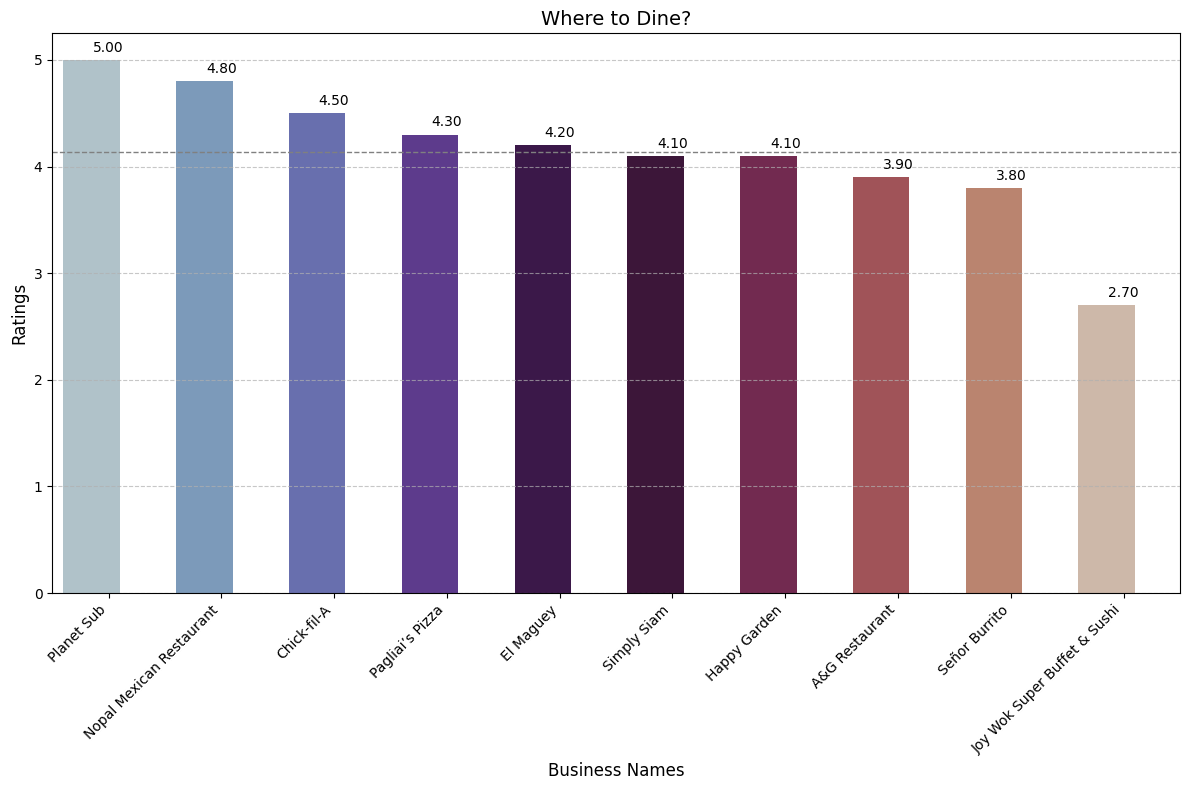

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

business_names = list(business_ratings.keys())
ratings = [float(rating) for rating in business_ratings.values()]


sorted_data = sorted(zip(business_names, ratings), key=lambda x: x[1], reverse=True)
business_names_sorted, ratings_sorted = zip(*sorted_data)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=business_names_sorted, y=ratings_sorted, palette='twilight', saturation=0.8)


for patch in ax.patches:
    patch.set_width(0.5)

average_rating = sum(ratings_sorted) / len(ratings_sorted)
ax.axhline(average_rating, color='grey', linestyle='--', linewidth=1)

for i, rating in enumerate(ratings_sorted):
    ax.text(i, rating + 0.05, f'{rating:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Business Names', fontsize=12)
plt.ylabel('Ratings', fontsize=12)
plt.title('Where to Dine?', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



In [29]:
business_reviews = {}

for key, value in business_review_urls.items():
    url = value
    full_review_response = requests.get(url)
    if full_review_response.status_code == 200:
        review_soup = BeautifulSoup(full_review_response.content, 'html.parser')
        review_paragraphs = review_soup.find_all('p', class_='comment__09f24__D0cxf css-qgunke')
        reviews = []
        for review in review_paragraphs:
            review_text = review.find('span', class_='raw__09f24__T4Ezm').text
            reviews.append(review_text)
            
        business_reviews[key] = reviews


In [30]:
#Storing the reviews in pickle file
import pickle

with open("business_reviews.pkl", "wb") as f:
    pickle.dump(business_reviews, f)


In [31]:
with open ('business_reviews.pkl', 'rb') as f:
    loaded_business_reviews = pickle.load(f)

In [32]:
# Iterate over the loaded_business_reviews from pickle file
for business, reviews in loaded_business_reviews.items():
    num_reviews = len(reviews)
    print(f"Business: {business}")
    print(f"Number of reviews: {num_reviews}")
    print()

Business: A&G Restaurant
Number of reviews: 10

Business: Pagliai’s Pizza
Number of reviews: 10

Business: El Maguey
Number of reviews: 10

Business: Nopal Mexican Restaurant
Number of reviews: 4

Business: Chick-fil-A
Number of reviews: 2

Business: Joy Wok Super Buffet & Sushi
Number of reviews: 10

Business: Simply Siam
Number of reviews: 10

Business: Happy Garden
Number of reviews: 0

Business: Señor Burrito
Number of reviews: 10

Business: Planet Sub
Number of reviews: 2



# Sentiment Analysis for each business using spaCy model

In [33]:
import spacy
nlp = spacy.load('en_core_web_sm')
from spacytextblob.spacytextblob import SpacyTextBlob

nlp.add_pipe('spacytextblob')


In [34]:
# Dictionary to store sentiment analysis results
business_sentiments = {}

# Perform sentiment analysis for each business
for business, reviews in loaded_business_reviews.items():
    positive_reviews = 0
    negative_reviews = 0
    neutral_reviews = 0
    
    # Iterate through reviews for the current business
    for review in reviews:
        doc = nlp(review)
        
       
        polarity = doc._.polarity
        
        # Classify sentiment based on the polarity component
        if polarity > 0.5:
            positive_reviews += 1
        elif polarity < -0.5:
            negative_reviews += 1
        else:
            neutral_reviews += 1
    
   
    business_sentiments[business] = {
        'positive_reviews': positive_reviews,
        'negative_reviews': negative_reviews,
        'neutral_reviews': neutral_reviews
    }

for business, sentiment_info in business_sentiments.items():
    print(f"Business: {business}")
    print(f"Positive Reviews: {sentiment_info['positive_reviews']}")
    print(f"Negative Reviews: {sentiment_info['negative_reviews']}")
    print(f"Neutral Reviews: {sentiment_info['neutral_reviews']}")
    print()


Business: A&G Restaurant
Positive Reviews: 2
Negative Reviews: 0
Neutral Reviews: 8

Business: Pagliai’s Pizza
Positive Reviews: 4
Negative Reviews: 0
Neutral Reviews: 6

Business: El Maguey
Positive Reviews: 3
Negative Reviews: 0
Neutral Reviews: 7

Business: Nopal Mexican Restaurant
Positive Reviews: 1
Negative Reviews: 0
Neutral Reviews: 3

Business: Chick-fil-A
Positive Reviews: 0
Negative Reviews: 0
Neutral Reviews: 2

Business: Joy Wok Super Buffet & Sushi
Positive Reviews: 1
Negative Reviews: 0
Neutral Reviews: 9

Business: Simply Siam
Positive Reviews: 2
Negative Reviews: 0
Neutral Reviews: 8

Business: Happy Garden
Positive Reviews: 0
Negative Reviews: 0
Neutral Reviews: 0

Business: Señor Burrito
Positive Reviews: 0
Negative Reviews: 0
Neutral Reviews: 10

Business: Planet Sub
Positive Reviews: 0
Negative Reviews: 0
Neutral Reviews: 2



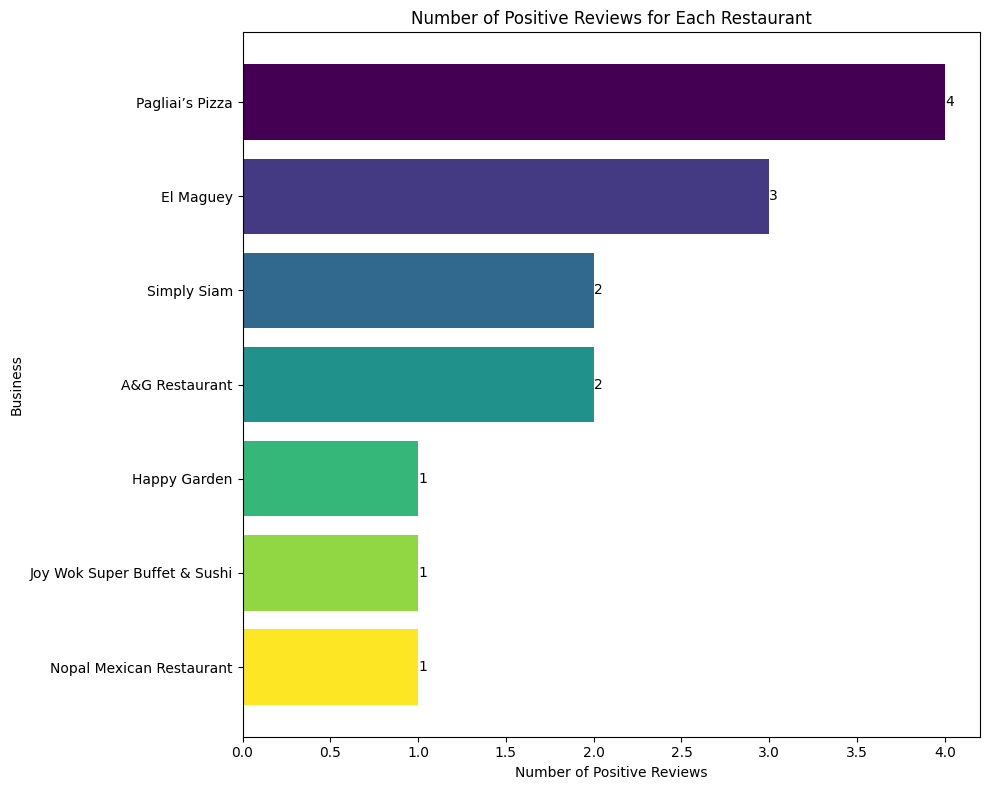

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Extract business names and positive review counts
business_names = list(business_sentiments.keys())
positive_review_counts = [sentiment_info['positive_reviews'] for sentiment_info in business_sentiments.values()]

# Filter out businesses with zero positive reviews
non_zero_indices = [i for i, count in enumerate(positive_review_counts) if count > 0]
business_names_filtered = [business_names[i] for i in non_zero_indices]
positive_review_counts_filtered = [positive_review_counts[i] for i in non_zero_indices]

sorted_indices = np.argsort(positive_review_counts_filtered)[::-1]  # Reverse order for descending sorting
business_names_sorted = [business_names_filtered[i] for i in sorted_indices]
positive_review_counts_sorted = [positive_review_counts_filtered[i] for i in sorted_indices]

plt.figure(figsize=(10, 8))
bars = plt.barh(business_names_sorted, positive_review_counts_sorted, color=plt.cm.viridis(np.linspace(0, 1, len(business_names_sorted))))
plt.xlabel('Number of Positive Reviews')
plt.ylabel('Business')
plt.title('Number of Positive Reviews for Each Restaurant')
plt.gca().invert_yaxis() 


for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}', va='center', ha='left')

plt.tight_layout()
plt.show()
